# Business Scenario

When deciding upon resourcing plans it is important to consider likely fault volumes.  Since the orders that fuel the provision work are typically taken 2 weeks in advance, a forward looking forecast of fault volumes would enable a more accurate prediction of the number of provision volumes to take on each week. 
<br>
You have been provided with the fault volume and rainfall data for a single geographic area for 3 years. Please use this data to create a model to predict the expected daily fault intake based on weather events.  Detailed explanation of the fields provided is given below.
<br>
At the interview you will be given 10 minutes to present your findings. The presentation should give an overview of your findings and be targeted at a senior stakeholder level. Please provide a copy of your findings for review before the interview. 
<br>
<br>
Things you may want to consider in the model;
<br>
1	Both short term and long term impact of rainfall
<br>
2	Impact of weather events on different fault types
<br>
3	Other things that might impact fault volume
<br>
<br>
Data provided:
<br>
Fault Data:  This contains information of individual faults for a single region over a 4 year period.
<br>
Fault ID:  Fault identifier    
<br>
Report Date: The date that the fault was reported
<br>
Initial MFL: Location of the fault;
<br>
CA: Customer appointed (home)
<br>
CE: D-side overhead network
<br>
EX: Exchange
<br>
FU: Frames (exchange)
<br>
LN: E-side Underground network
<br>
OK: Line has tested OK
<br>
OTHER: Other faults
<br>
Rainfall: This contains daily rainfall information for the same 4 year period
<br>
Observation Date: Date	
Rainfall mm: Rainfall (in mm)
<br>
Calendar Lookup: This contains a lookup to give calendar information such as day of week and bank holidays
<br>
Actual Date: Date
<br>
Day of Week: Day of Week	
Day Num Cal Week: Numeric value of day within the week	
Day Num Cal Month: Numeric value of day within the month
<br>
Day Num Cal Year: Numeric value of day within the year
<br>
Bank holiday: Flags the bank holiday (Y: bank holiday)

In [544]:
# Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
import datetime
from datetime import timedelta,datetime
from sklearn import metrics

In [692]:
X = pd.read_excel('RainFallData.xlsx',index_col = 0)
Y = pd.read_excel('FaultData.xlsx', index_col = 0)

In [693]:
X['OBS_DATE'] = X.index
print(X)

                  RAINFALL_MM   OBS_DATE
OBSERVATION_DATE                        
2014-01-01               10.6 2014-01-01
2014-01-02                4.2 2014-01-02
2014-01-03                5.8 2014-01-03
2014-01-04                1.8 2014-01-04
2014-01-05               11.0 2014-01-05
2014-01-06                5.6 2014-01-06
2014-01-07                5.9 2014-01-07
2014-01-08               14.8 2014-01-08
2014-01-09                0.8 2014-01-09
2014-01-10                5.2 2014-01-10
2014-01-11                0.2 2014-01-11
2014-01-12                3.8 2014-01-12
2014-01-13                8.1 2014-01-13
2014-01-14                7.6 2014-01-14
2014-01-15                5.3 2014-01-15
2014-01-16                3.3 2014-01-16
2014-01-17                2.0 2014-01-17
2014-01-18                9.2 2014-01-18
2014-01-19                2.6 2014-01-19
2014-01-20                0.2 2014-01-20
2014-01-21                5.6 2014-01-21
2014-01-22                2.3 2014-01-22
2014-01-23      

In [694]:
# Rainfall Every 1 to 7 Days     
X['1_Day_Rain'] = [X['RAINFALL_MM'][max(0,i-1)] for i in range(0,len(X))]
X['2_Day_Rain'] = [X['RAINFALL_MM'][max(0,i-2)] for i in range(0,len(X))]
X['3_Day_Rain'] = [X['RAINFALL_MM'][max(0,i-3)] for i in range(0,len(X))]
X['4_Day_Rain'] = [X['RAINFALL_MM'][max(0,i-4)] for i in range(0,len(X))]
X['5_Day_Rain'] = [X['RAINFALL_MM'][max(0,i-5)] for i in range(0,len(X))]
X['6_Day_Rain'] = [X['RAINFALL_MM'][max(0,i-6)] for i in range(0,len(X))]
X['7_Day_Rain'] = [X['RAINFALL_MM'][max(0,i-7)] for i in range(0,len(X))]

## Cummulative Rain for each week
X['Cummulative_Rain'] = [sum(X['RAINFALL_MM'][max(0,i-7):i]) for i in range(0,len(X))]
X['YMD'] = [X['OBS_DATE'][i].year*10000+X['OBS_DATE'][i].month*100+X['OBS_DATE'][i].day for i in range(0,len(X))]
X

,RAINFALL_MM,OBS_DATE,1_Day_Rain,2_Day_Rain,3_Day_Rain,4_Day_Rain,5_Day_Rain,6_Day_Rain,7_Day_Rain,Cummulative_Rain,YMD
OBSERVATION_DATE,,,,,,,,,,,
2014-01-01,10.6,2014-01-01,10.6,10.6,10.6,10.6,10.6,10.6,10.6,0.0,20140101
2014-01-02,4.2,2014-01-02,10.6,10.6,10.6,10.6,10.6,10.6,10.6,10.6,20140102
2014-01-03,5.8,2014-01-03,4.2,10.6,10.6,10.6,10.6,10.6,10.6,14.8,20140103
2014-01-04,1.8,2014-01-04,5.8,4.2,10.6,10.6,10.6,10.6,10.6,20.6,20140104
2014-01-05,11.0,2014-01-05,1.8,5.8,4.2,10.6,10.6,10.6,10.6,22.4,20140105
2014-01-06,5.6,2014-01-06,11.0,1.8,5.8,4.2,10.6,10.6,10.6,33.4,20140106
2014-01-07,5.9,2014-01-07,5.6,11.0,1.8,5.8,4.2,10.6,10.6,39.0,20140107
2014-01-08,14.8,2014-01-08,5.9,5.6,11.0,1.8,5.8,4.2,10.6,44.9,20140108
2014-01-09,0.8,2014-01-09,14.8,5.9,5.6,11.0,1.8,5.8,4.2,49.1,20140109


In [695]:
print(type(X))
print(type(Y))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### Calculate Different types of Faults for 7, 14 and 21 Days

In [696]:
Y.head()
(Y['REPORT_DATE'][0]).day

1

In [697]:
Y['YMD'] = [Y['REPORT_DATE'][i].year*10000+Y['REPORT_DATE'][i].month*100+Y['REPORT_DATE'][i].day for i in range(0,len(Y))]
Y.head()

,REPORT_DATE,INITIAL_MFL,YMD
Fault ID,,,
ID000001,2014-01-01,CE,20140101
ID000002,2014-01-01,CA,20140101
ID000003,2014-01-01,OTHER,20140101
ID000004,2014-01-01,OK,20140101
ID000005,2014-01-01,LN,20140101


In [698]:
Y['COUNT'] = 1
Z = pd.pivot_table(Y,values=['COUNT'],index='YMD',columns='INITIAL_MFL',aggfunc=sum).reset_index()

In [699]:
Z.columns=['YMD','FAULTS_CA','FAULTS_CE','FAULTS_EX','FAULTS_FU','FAULTS_LN','FAULTS_OK','FAULTS_OTHER']
Z.head()

,YMD,FAULTS_CA,FAULTS_CE,FAULTS_EX,FAULTS_FU,FAULTS_LN,FAULTS_OK,FAULTS_OTHER
0,20140101,15.0,40.0,6.0,4.0,38.0,26.0,17.0
1,20140102,47.0,100.0,3.0,13.0,67.0,83.0,24.0
2,20140103,63.0,87.0,6.0,14.0,77.0,79.0,28.0
3,20140104,24.0,60.0,3.0,6.0,34.0,47.0,8.0
4,20140105,16.0,28.0,2.0,4.0,31.0,41.0,9.0


In [700]:
for fault in Z.columns[1:]:
    newfault = fault.replace('FAULTS_','15to21Faults_')    
    Z[fault]=Z[fault].fillna(0).replace(np.nan,0)
    Z[newfault]=[sum(Z[fault][min(i+14,len(Z)):min(i+21,len(Z))]) for i in range(0,len(Z))]

In [701]:
Z.tail(50)

,YMD,FAULTS_CA,FAULTS_CE,FAULTS_EX,FAULTS_FU,FAULTS_LN,FAULTS_OK,FAULTS_OTHER,15to21Faults_CA,15to21Faults_CE,15to21Faults_EX,15to21Faults_FU,15to21Faults_LN,15to21Faults_OK,15to21Faults_OTHER
1136,20170210,13.0,89.0,0.0,12.0,37.0,76.0,5.0,243.0,833.0,9.0,89.0,379.0,573.0,86.0
1137,20170211,16.0,56.0,0.0,6.0,27.0,47.0,5.0,227.0,716.0,11.0,94.0,333.0,546.0,84.0
1138,20170212,15.0,40.0,1.0,3.0,10.0,46.0,3.0,211.0,685.0,11.0,95.0,302.0,542.0,80.0
1139,20170213,29.0,84.0,6.0,14.0,36.0,81.0,10.0,200.0,667.0,10.0,89.0,297.0,536.0,77.0
1140,20170214,20.0,85.0,2.0,10.0,34.0,75.0,15.0,208.0,671.0,7.0,80.0,283.0,541.0,72.0
1141,20170215,26.0,101.0,3.0,13.0,33.0,108.0,12.0,208.0,655.0,9.0,80.0,241.0,553.0,75.0
1142,20170216,25.0,77.0,2.0,10.0,25.0,80.0,7.0,213.0,646.0,10.0,89.0,230.0,554.0,68.0
1143,20170217,21.0,66.0,1.0,17.0,27.0,72.0,8.0,190.0,620.0,11.0,87.0,229.0,566.0,68.0
1144,20170218,10.0,57.0,0.0,13.0,24.0,51.0,6.0,198.0,600.0,21.0,83.0,232.0,567.0,67.0
1145,20170219,12.0,39.0,9.0,3.0,3.0,46.0,3.0,198.0,609.0,20.0,80.0,231.0,572.0,62.0


In [702]:
## Merge DataFrame
df=X.merge(Z,on='YMD')
df = df[7:len(df)-21]
df = df.reset_index()
df

,index,RAINFALL_MM,OBS_DATE,1_Day_Rain,2_Day_Rain,3_Day_Rain,4_Day_Rain,5_Day_Rain,6_Day_Rain,7_Day_Rain,...,FAULTS_LN,FAULTS_OK,FAULTS_OTHER,15to21Faults_CA,15to21Faults_CE,15to21Faults_EX,15to21Faults_FU,15to21Faults_LN,15to21Faults_OK,15to21Faults_OTHER
0,7,14.8,2014-01-08,5.9,5.6,11.0,1.8,5.8,4.2,10.6,...,61.0,93.0,68.0,386.0,641.0,28.0,154.0,436.0,562.0,150.0
1,8,0.8,2014-01-09,14.8,5.9,5.6,11.0,1.8,5.8,4.2,...,54.0,92.0,26.0,414.0,650.0,17.0,170.0,463.0,587.0,157.0
2,9,5.2,2014-01-10,0.8,14.8,5.9,5.6,11.0,1.8,5.8,...,65.0,69.0,15.0,436.0,646.0,15.0,177.0,470.0,583.0,162.0
3,10,0.2,2014-01-11,5.2,0.8,14.8,5.9,5.6,11.0,1.8,...,22.0,45.0,11.0,439.0,657.0,13.0,176.0,491.0,606.0,164.0
4,11,3.8,2014-01-12,0.2,5.2,0.8,14.8,5.9,5.6,11.0,...,27.0,38.0,9.0,393.0,601.0,13.0,145.0,440.0,604.0,149.0
5,12,8.1,2014-01-13,3.8,0.2,5.2,0.8,14.8,5.9,5.6,...,82.0,71.0,16.0,331.0,560.0,12.0,118.0,411.0,561.0,143.0
6,13,7.6,2014-01-14,8.1,3.8,0.2,5.2,0.8,14.8,5.9,...,63.0,93.0,41.0,270.0,530.0,13.0,100.0,367.0,507.0,120.0
7,14,5.3,2014-01-15,7.6,8.1,3.8,0.2,5.2,0.8,14.8,...,65.0,87.0,21.0,252.0,532.0,7.0,100.0,338.0,480.0,118.0
8,15,3.3,2014-01-16,5.3,7.6,8.1,3.8,0.2,5.2,0.8,...,48.0,71.0,17.0,233.0,525.0,9.0,89.0,312.0,451.0,106.0
9,16,2.0,2014-01-17,3.3,5.3,7.6,8.1,3.8,0.2,5.2,...,59.0,55.0,13.0,241.0,512.0,17.0,75.0,315.0,442.0,105.0


In [703]:
train, test = train_test_split(df, test_size=0.2)

In [704]:
train.head()

,index,RAINFALL_MM,OBS_DATE,1_Day_Rain,2_Day_Rain,3_Day_Rain,4_Day_Rain,5_Day_Rain,6_Day_Rain,7_Day_Rain,...,FAULTS_LN,FAULTS_OK,FAULTS_OTHER,15to21Faults_CA,15to21Faults_CE,15to21Faults_EX,15to21Faults_FU,15to21Faults_LN,15to21Faults_OK,15to21Faults_OTHER
860,867,0.0,2016-05-16,0.0,0.0,0.0,0.0,2.2,10.5,3.6,...,31.0,106.0,7.0,122.0,353.0,10.0,66.0,153.0,402.0,44.0
840,847,2.0,2016-04-26,1.8,0.6,0.1,0.0,0.0,0.0,0.0,...,44.0,72.0,8.0,155.0,387.0,11.0,96.0,232.0,482.0,38.0
987,994,0.0,2016-09-20,0.0,3.9,0.0,0.1,0.2,0.0,5.0,...,40.0,103.0,15.0,183.0,428.0,38.0,80.0,231.0,597.0,68.0
452,459,0.0,2015-04-04,1.6,3.7,7.3,1.3,13.2,10.8,7.1,...,27.0,23.0,3.0,167.0,429.0,47.0,83.0,180.0,425.0,58.0
220,227,1.3,2014-08-16,0.5,1.3,1.7,1.8,0.6,7.9,9.0,...,21.0,46.0,8.0,128.0,359.0,16.0,75.0,172.0,432.0,64.0


In [705]:
test.head()

,index,RAINFALL_MM,OBS_DATE,1_Day_Rain,2_Day_Rain,3_Day_Rain,4_Day_Rain,5_Day_Rain,6_Day_Rain,7_Day_Rain,...,FAULTS_LN,FAULTS_OK,FAULTS_OTHER,15to21Faults_CA,15to21Faults_CE,15to21Faults_EX,15to21Faults_FU,15to21Faults_LN,15to21Faults_OK,15to21Faults_OTHER
985,992,3.9,2016-09-18,0.0,0.1,0.2,0.0,5.0,0.8,0.0,...,20.0,38.0,4.0,186.0,413.0,34.0,80.0,225.0,615.0,71.0
821,828,4.6,2016-04-07,8.2,2.4,3.2,11.4,6.1,11.6,0.1,...,48.0,81.0,15.0,164.0,407.0,25.0,105.0,227.0,493.0,60.0
966,973,2.3,2016-08-30,0.0,0.1,6.5,0.1,2.6,0.5,0.1,...,63.0,107.0,17.0,260.0,524.0,21.0,102.0,292.0,590.0,74.0
1132,1139,0.3,2017-02-12,1.1,0.0,0.0,0.0,1.5,6.7,0.1,...,10.0,46.0,3.0,211.0,685.0,11.0,95.0,302.0,542.0,80.0
67,74,0.2,2014-03-16,0.0,0.0,0.2,0.1,0.1,0.0,0.4,...,13.0,27.0,10.0,153.0,488.0,17.0,89.0,197.0,445.0,89.0


# CA - FAULT MODELS

## Linear Regression

In [931]:
# Split Train Test Data for CA Faults
df_ca = df[['Cummulative_Rain','15to21Faults_CA']]
df_ca_train, df_ca_test = train_test_split(df_ca, test_size=0.2,random_state=1801)

In [950]:
df_ca.corr()

,Cummulative_Rain,15to21Faults_CA
Cummulative_Rain,1.000000,0.293605
15to21Faults_CA,0.293605,1.000000


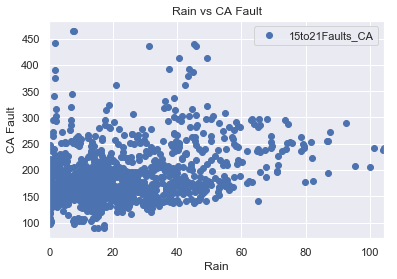

In [932]:
df_ca.plot(x='Cummulative_Rain', y='15to21Faults_CA', style='o')  
plt.title('Rain vs CA Fault')  
plt.xlabel('Rain')  
plt.ylabel('CA Fault')  
plt.show()

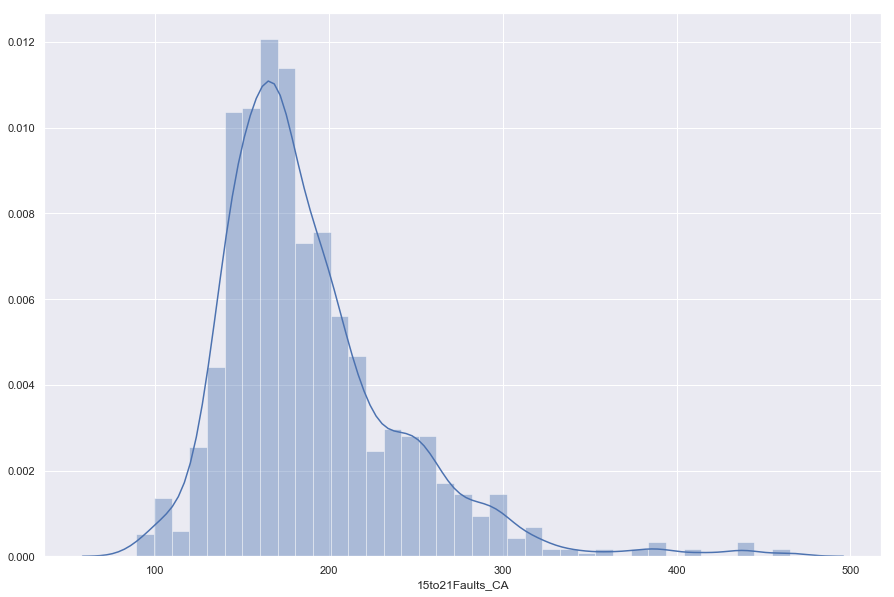

In [933]:
# Check Average Faults
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df_ca['15to21Faults_CA'])

In [934]:
# Find TRAIN Set Data for 15 to 21 Days for CA Faults
df_ca_train_np_rain=df_ca_train['Cummulative_Rain'].to_numpy()
df_ca_train_np_fault = df_ca_train['15to21Faults_CA'].to_numpy()

# Reshape test train data
df_ca_train_rain = df_ca_train_np_rain.reshape(len(df_ca_train_np_rain),1)
df_ca_train_fault = df_ca_train_np_fault.reshape(len(df_ca_train_np_fault),1)

In [935]:
lr = LinearRegression().fit(df_ca_train_rain,df_ca_train_fault)

In [936]:
print(lr.coef_)
print(lr.intercept_)

[[0.778806]]
[170.60607576]


In [937]:
# Find TEST Set Data for 15 to 21 Days for CA Faults
df_ca_test_np_rain=df_ca_test['Cummulative_Rain'].to_numpy()
df_ca_test_np_fault = df_ca_test['15to21Faults_CA'].to_numpy()

df_ca_test_rain = df_ca_test_np_rain.reshape(len(df_ca_test_np_rain),1)
df_ca_test_fault = df_ca_test_np_fault.reshape(len(df_ca_test_np_fault),1)

In [938]:
# Train Model Accuracy
lr.score(df_ca_train_rain, df_ca_train_fault)

0.07873837961092411

In [939]:
# testing model accuracy in test set
lr.score(df_ca_test_rain, df_ca_test_fault)

0.11870411713873263

[[210.01365913]
 [185.48127027]
 [190.93291224]
 [190.46562864]
 [207.83300234]
 [198.565211  ]
 [189.45318085]
 [251.75766048]
 [185.16974788]
 [189.92046445]
 [209.07909193]
 [199.11037519]
 [184.15730008]
 [200.35646479]
 [198.4094498 ]
 [190.54350924]
 [185.24762847]
 [179.87386711]
 [212.81736071]
 [214.2192115 ]
 [183.45637469]
 [172.08580715]
 [195.76150941]
 [197.00759901]
 [177.69321032]
 [225.90130143]
 [208.84545013]
 [192.33476303]
 [199.73341999]
 [187.11676286]
 [193.58085263]
 [196.15091241]
 [190.38774804]
 [194.20389742]
 [193.81449442]
 [172.16368775]
 [195.83939001]
 [178.23837452]
 [170.76183696]
 [195.44998701]
 [188.28497186]
 [193.19144963]
 [187.03888226]
 [172.39732955]
 [215.3095399 ]
 [190.23198685]
 [189.29741965]
 [171.85216535]
 [176.13559833]
 [175.59043413]
 [187.81768826]
 [195.29422582]
 [202.84864397]
 [211.64915172]
 [197.7085244 ]
 [186.80524047]
 [170.83971756]
 [186.41583747]
 [181.0420761 ]
 [183.69001648]
 [170.60607576]
 [180.1853895 ]
 [207.28

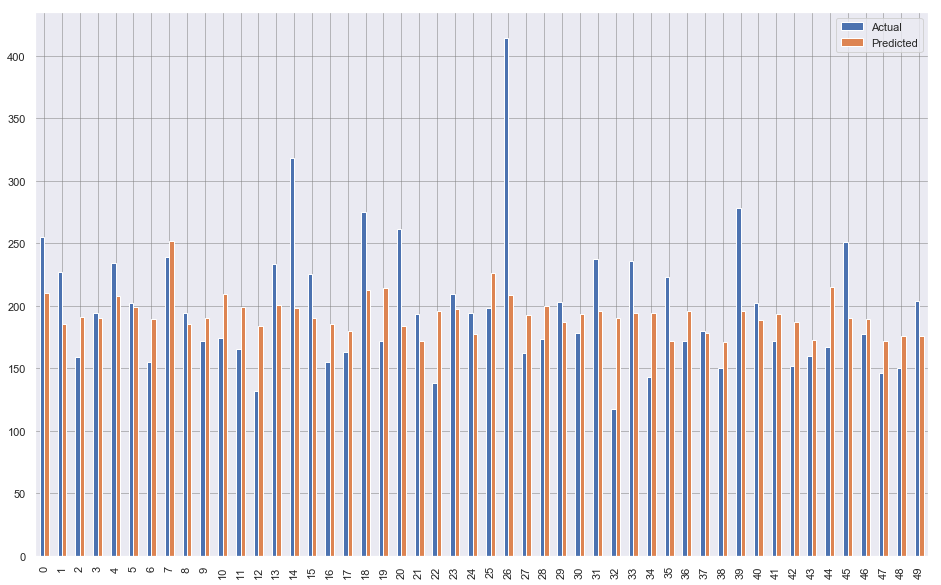

In [958]:
predict_linear = lr.predict(df_ca_test_rain)
print(predict_linear)
actual_pred_linear= pd.DataFrame({'Actual': df_ca_test_fault.flatten(), 'Predicted': predict_linear.flatten()})
bar_plot_df = actual_pred_linear.head(50)
bar_plot_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

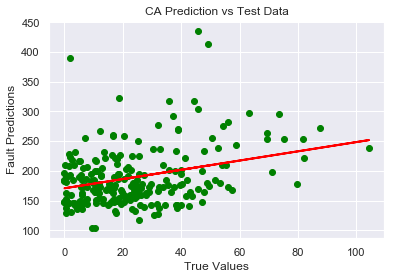

In [949]:
plt.scatter(df_ca_test_rain, df_ca_test_fault,  color='green')
plt.plot(df_ca_test_rain, predict_linear, color='red', linewidth=2)
plt.title('CA Prediction vs Test Data') 
plt.xlabel('True Values')
plt.ylabel('Fault Predictions')
plt.show()

In [728]:
rmspe = (np.sqrt(np.mean(np.square((df_ca_test_fault - predict_linear) / df_ca_test_fault)))) * 100
print('Root Mean Squared Error Percentage for CA Faults: ', rmspe,'%')

Root Mean Squared Error Percentage for CA Faults:  22.58179783574731 %


# OK FAULT MODELS

In [729]:
df_ok = df[['Cummulative_Rain','15to21Faults_OK']]
df_ok_train, df_ok_test = train_test_split(df_ok, test_size=0.2,random_state=1801)

In [951]:
df_ok.corr()

,Cummulative_Rain,15to21Faults_OK
Cummulative_Rain,1.000000,0.109644
15to21Faults_OK,0.109644,1.000000


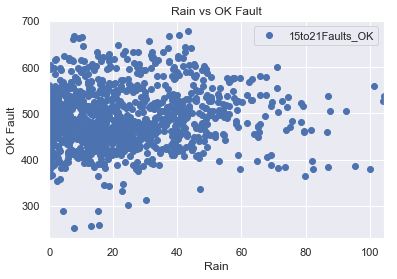

In [730]:
df_ok.plot(x='Cummulative_Rain', y='15to21Faults_OK', style='o')  
plt.title('Rain vs OK Fault')  
plt.xlabel('Rain')  
plt.ylabel('OK Fault')  
plt.show()

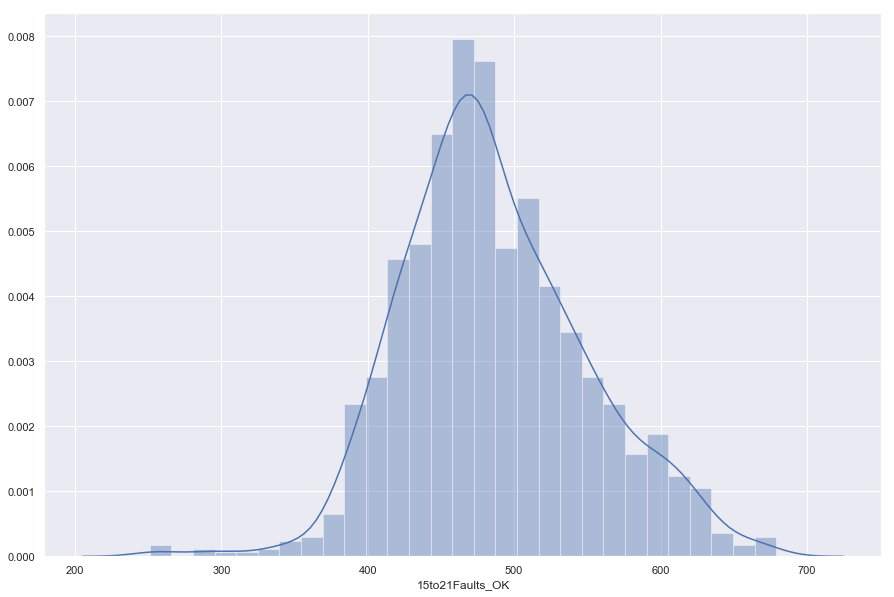

In [731]:
# Check Average Faults
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df_ok['15to21Faults_OK'])

In [732]:
# Find TRAIN Set Data for 15 to 21 Days for OK Faults
df_ok_train_np_rain=df_ok_train['Cummulative_Rain'].to_numpy()
df_ok_train_np_fault = df_ok_train['15to21Faults_OK'].to_numpy()

# Reshape test train data
df_ok_train_rain = df_ok_train_np_rain.reshape(len(df_ok_train_np_rain),1)
df_ok_train_fault = df_ok_train_np_fault.reshape(len(df_ok_train_np_fault),1)

In [733]:
lr = LinearRegression().fit(df_ok_train_rain,df_ok_train_fault)

In [734]:
# Train Model Accuracy
lr.score(df_ok_train_rain, df_ok_train_fault)

0.022303093262508348

In [735]:
# Find TEST Set Data for 15 to 21 Days for OK Faults
df_ok_test_np_rain=df_ok_test['Cummulative_Rain'].to_numpy()
df_ok_test_np_fault = df_ok_test['15to21Faults_OK'].to_numpy()

df_ok_test_rain = df_ok_test_np_rain.reshape(len(df_ok_test_np_rain),1)
df_ok_test_fault = df_ok_test_np_fault.reshape(len(df_ok_test_np_fault),1)

In [736]:
# testing model accuracy in test set
lr.score(df_ok_test_rain, df_ok_test_fault)

-0.05419377300430939

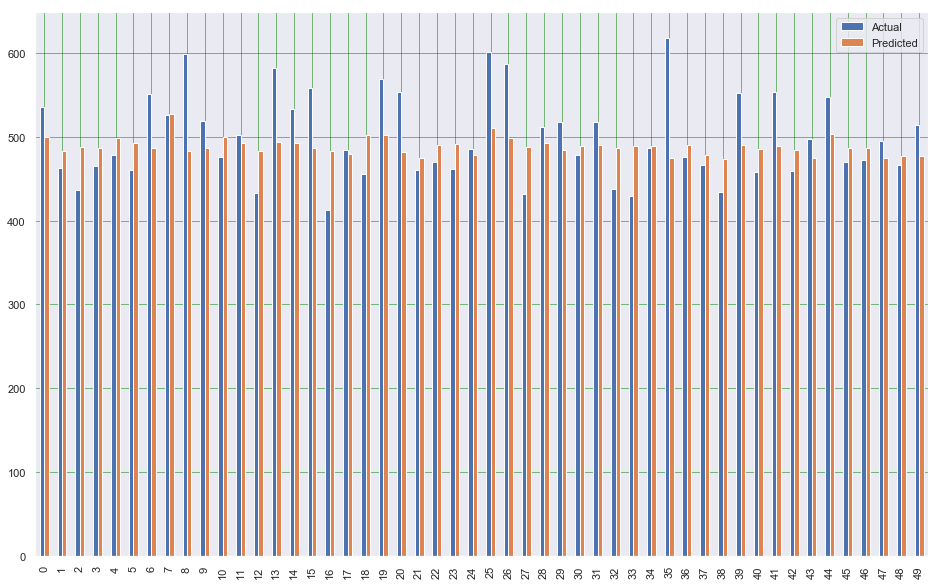

In [737]:
pred_OK_Fault_linear = lr.predict(df_ok_test_rain)
OK_actual_pred_linear= pd.DataFrame({'Actual': df_ok_test_fault.flatten(), 'Predicted': pred_OK_Fault_linear.flatten()})
bar_plot_df = OK_actual_pred_linear.head(50)
bar_plot_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

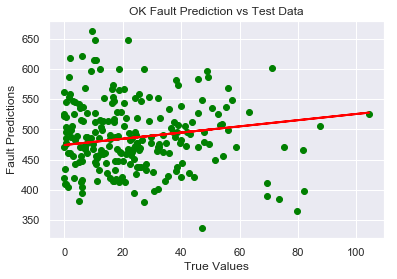

In [943]:
plt.scatter(df_ok_test_rain, df_ok_test_fault,  color='green')
plt.plot(df_ok_test_rain, pred_OK_Fault_linear, color='red', linewidth=2)
plt.title('OK Fault Prediction vs Test Data')
plt.xlabel('True Values')
plt.ylabel('Fault Predictions')
plt.show()

In [808]:
rmspe_ok = (np.sqrt(np.mean(np.square((df_ok_test_fault - pred_OK_Fault_linear) / df_ok_test_fault)))) * 100
print('Root Mean Squared Error Percentage for OK Faults: ', rmspe_ok,'%')

Root Mean Squared Error Percentage for OK Faults:  12.093466744257546 %


# CE FAULT MODEL

## Linear Regression on Faults CE

In [740]:
df_ce = df[['Cummulative_Rain','15to21Faults_CE']]
df_ce_train, df_ce_test = train_test_split(df_ce, test_size=0.2,random_state=1801)

In [952]:
df_ce.corr()

,Cummulative_Rain,15to21Faults_CE
Cummulative_Rain,1.000000,0.248735
15to21Faults_CE,0.248735,1.000000


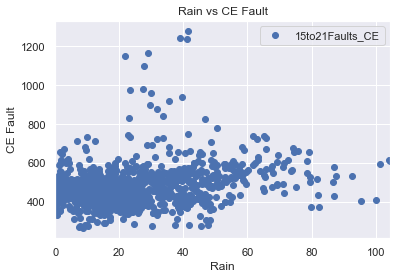

In [741]:
df_ce.plot(x='Cummulative_Rain', y='15to21Faults_CE', style='o')  
plt.title('Rain vs CE Fault')  
plt.xlabel('Rain')  
plt.ylabel('CE Fault')  
plt.show()

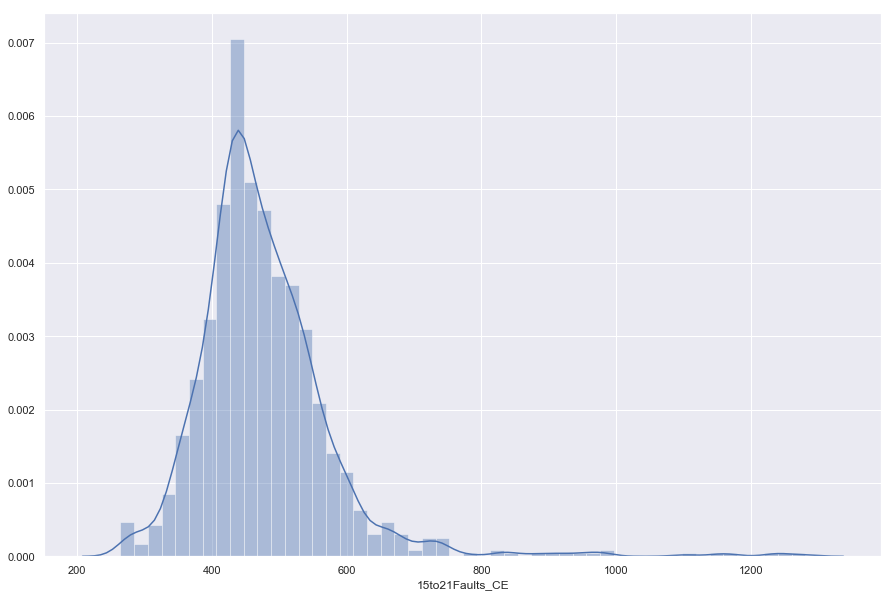

In [742]:
# Check Average Faults
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df_ce['15to21Faults_CE'])

In [743]:
# Find TRAIN Set Data for 15 to 21 Days for CA Faults
df_ce_train_np_rain=df_ce_train['Cummulative_Rain'].to_numpy()
df_ce_train_np_fault = df_ce_train['15to21Faults_CE'].to_numpy()

# Reshape test train data
df_ce_train_rain = df_ce_train_np_rain.reshape(len(df_ce_train_np_rain),1)
df_ce_train_fault = df_ce_train_np_fault.reshape(len(df_ce_train_np_fault),1)

In [744]:
lr = LinearRegression().fit(df_ce_train_rain,df_ce_train_fault)

In [745]:
lr.score(df_ce_train_rain, df_ce_train_fault)

0.06342011283905269

In [746]:
# Find TEST Set Data for 15 to 21 Days for CA Faults
df_ce_test_np_rain=df_ce_test['Cummulative_Rain'].to_numpy()
df_ce_test_np_fault = df_ce_test['15to21Faults_CE'].to_numpy()

df_ce_test_rain = df_ce_test_np_rain.reshape(len(df_ce_test_np_rain),1)
df_ce_test_fault = df_ce_test_np_fault.reshape(len(df_ce_test_np_fault),1)

In [747]:
# testing model accuracy in test set
lr.score(df_ce_test_rain, df_ce_test_fault)

0.04189087198405883

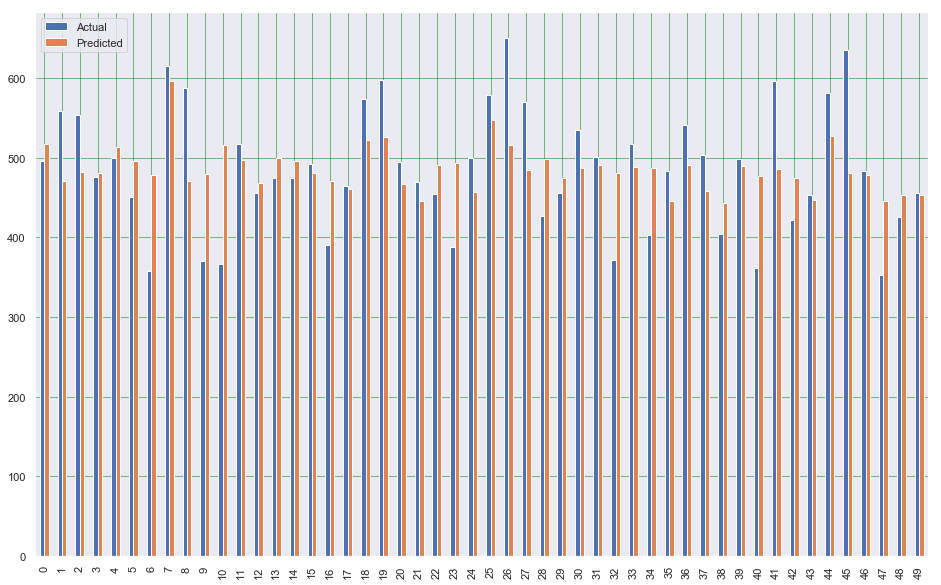

In [748]:
pred_ce_Fault_linear = lr.predict(df_ce_test_rain)
ce_actual_pred_linear= pd.DataFrame({'Actual': df_ce_test_fault.flatten(), 'Predicted': pred_ce_Fault_linear.flatten()})
bar_plot_df = ce_actual_pred_linear.head(50)
bar_plot_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

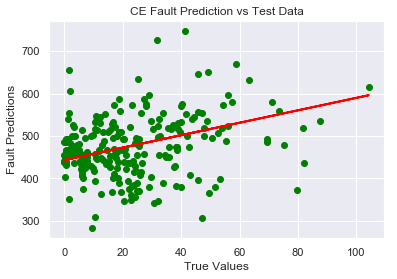

In [944]:
plt.scatter(df_ce_test_rain, df_ce_test_fault,  color='green')
plt.plot(df_ce_test_rain, pred_ce_Fault_linear, color='red', linewidth=2)
plt.title('CE Fault Prediction vs Test Data') 
plt.xlabel('True Values')
plt.ylabel('Fault Predictions')
plt.show()

In [750]:
rmspe_ce = (np.sqrt(np.mean(np.square((df_ce_test_fault - pred_ce_Fault_linear) / df_ce_test_fault)))) * 100
print('Root Mean Squared Error Percentage for CE Faults: ', rmspe_ok,'%')

Root Mean Squared Error Percentage for CE Faults:  12.093466744257546 %


# EX FAULT MODEL

## Linear Regression

In [751]:
df_ex = df[['Cummulative_Rain','15to21Faults_EX']]
df_ex_train, df_ex_test = train_test_split(df_ex, test_size=0.2,random_state=1801)

In [953]:
df_ex.corr()

,Cummulative_Rain,15to21Faults_EX
Cummulative_Rain,1.000000,0.014196
15to21Faults_EX,0.014196,1.000000


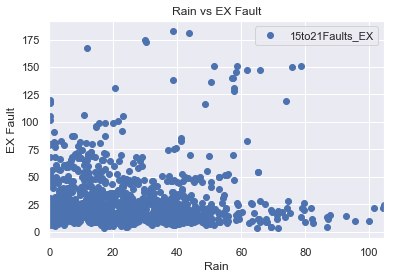

In [752]:
df_ex.plot(x='Cummulative_Rain', y='15to21Faults_EX', style='o')  
plt.title('Rain vs EX Fault')  
plt.xlabel('Rain')  
plt.ylabel('EX Fault')  
plt.show()

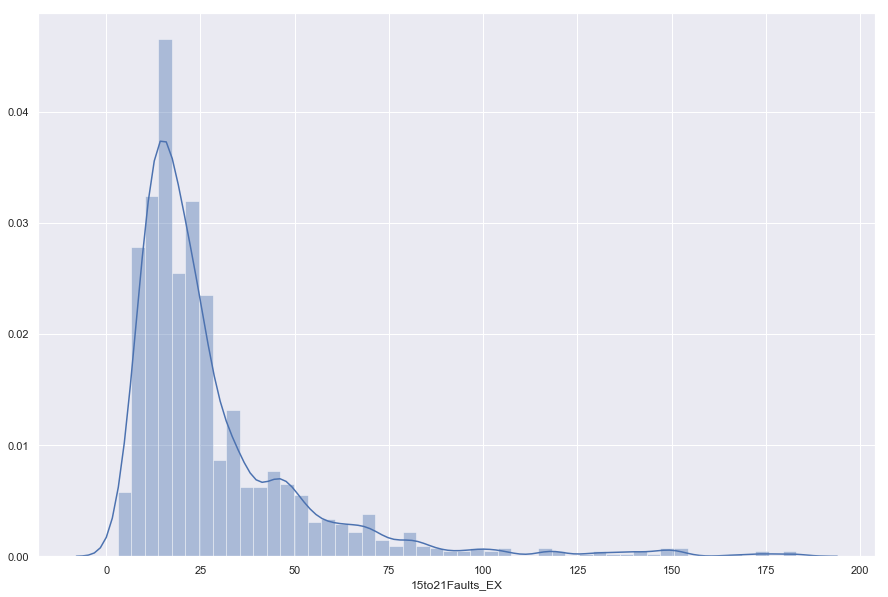

In [753]:
# Check Average Faults
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df_ex['15to21Faults_EX'])

In [754]:
# Find TRAIN Set Data for 15 to 21 Days for CA Faults
df_ex_train_np_rain=df_ex_train['Cummulative_Rain'].to_numpy()
df_ex_train_np_fault = df_ex_train['15to21Faults_EX'].to_numpy()

# Reshape test train data
df_ex_train_rain = df_ex_train_np_rain.reshape(len(df_ex_train_np_rain),1)
df_ex_train_fault = df_ex_train_np_fault.reshape(len(df_ex_train_np_fault),1)

In [755]:
lr = LinearRegression().fit(df_ex_train_rain,df_ex_train_fault)

In [756]:
lr.score(df_ex_train_rain, df_ex_train_fault)

0.0009182826737963444

In [757]:
# Find TEST Set Data for 15 to 21 Days for CA Faults
df_ex_test_np_rain=df_ex_test['Cummulative_Rain'].to_numpy()
df_ex_test_np_fault = df_ex_test['15to21Faults_EX'].to_numpy()

df_ex_test_rain = df_ex_test_np_rain.reshape(len(df_ex_test_np_rain),1)
df_ex_test_fault = df_ex_test_np_fault.reshape(len(df_ex_test_np_fault),1)

In [758]:
# testing model accuracy in test set
lr.score(df_ex_test_rain, df_ex_test_fault)

-0.00497290884903534

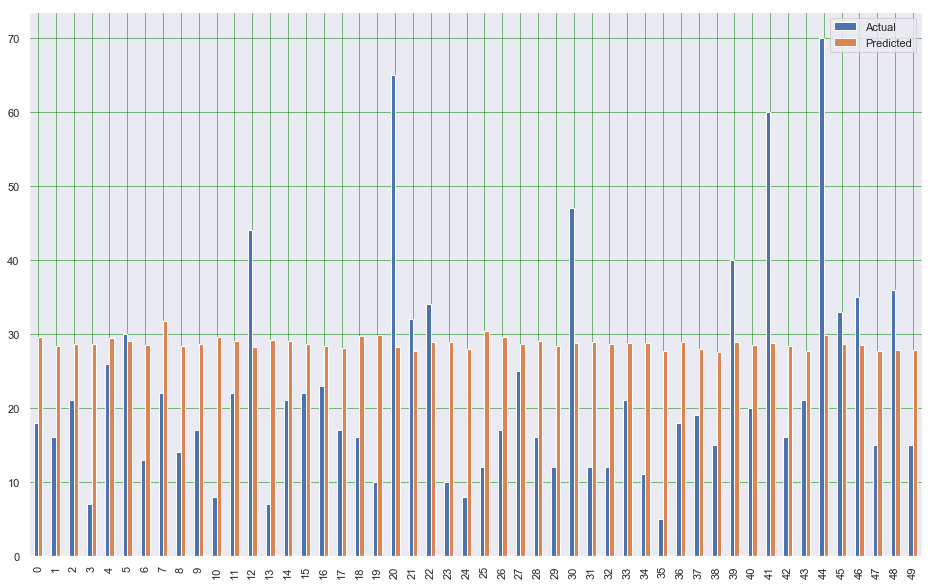

In [759]:
pred_ex_Fault_linear = lr.predict(df_ex_test_rain)
ex_actual_pred_linear= pd.DataFrame({'Actual': df_ex_test_fault.flatten(), 'Predicted': pred_ex_Fault_linear.flatten()})
bar_plot_df = ex_actual_pred_linear.head(50)
bar_plot_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

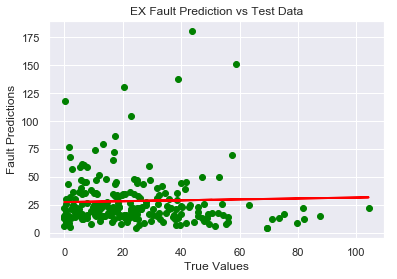

In [945]:
plt.scatter(df_ex_test_rain, df_ex_test_fault,  color='green')
plt.plot(df_ex_test_rain, pred_ex_Fault_linear, color='red', linewidth=2)
plt.title('EX Fault Prediction vs Test Data') 
plt.xlabel('True Values')
plt.ylabel('Fault Predictions')
plt.show()

In [761]:
rmspe_ex = (np.sqrt(np.mean(np.square((df_ex_test_fault - pred_ex_Fault_linear) / df_ex_test_fault)))) * 100
print('Root Mean Squared Error Percentage for EX Faults: ', rmspe_ex,'%')

Root Mean Squared Error Percentage for EX Faults:  125.6560203361075 %


# FU FAULT MODEL

## Linear Regression

In [762]:
df_fu = df[['Cummulative_Rain','15to21Faults_FU']]
df_fu_train, df_fu_test = train_test_split(df_fu, test_size=0.2,random_state=1801)

In [954]:
df_fu.corr()

,Cummulative_Rain,15to21Faults_FU
Cummulative_Rain,1.000000,0.157248
15to21Faults_FU,0.157248,1.000000


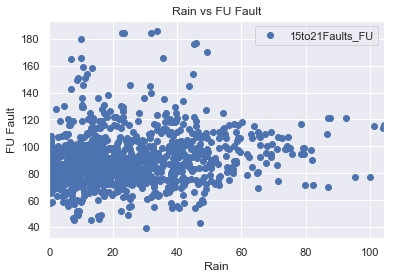

In [763]:
df_fu.plot(x='Cummulative_Rain', y='15to21Faults_FU', style='o')  
plt.title('Rain vs FU Fault')  
plt.xlabel('Rain')  
plt.ylabel('FU Fault')  
plt.show()

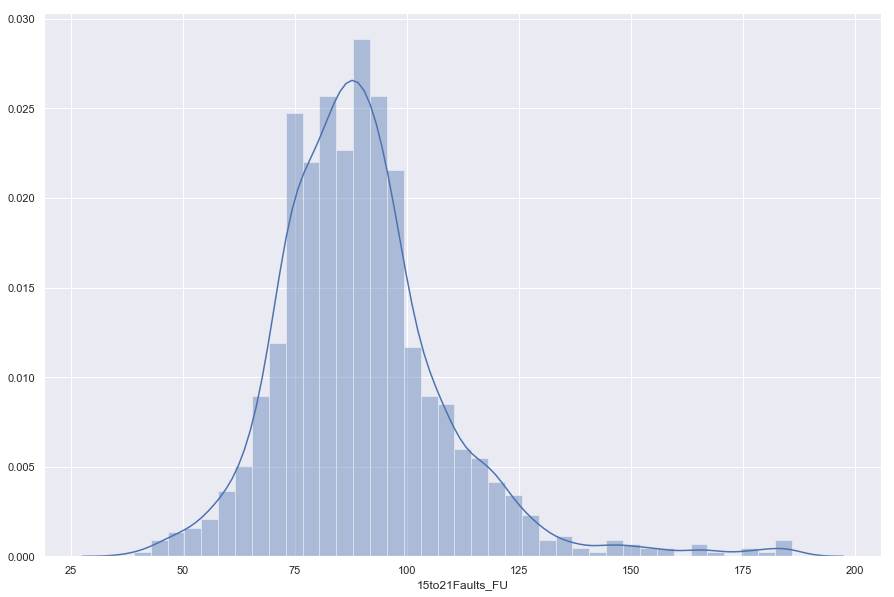

In [764]:
# Check Average Faults
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df_fu['15to21Faults_FU'])

In [765]:
# Find TRAIN Set Data for 15 to 21 Days for FU Faults
df_fu_train_np_rain=df_fu_train['Cummulative_Rain'].to_numpy()
df_fu_train_np_fault = df_fu_train['15to21Faults_FU'].to_numpy()

# Reshape test train data
df_fu_train_rain = df_fu_train_np_rain.reshape(len(df_fu_train_np_rain),1)
df_fu_train_fault = df_fu_train_np_fault.reshape(len(df_fu_train_np_fault),1)

In [766]:
lr = LinearRegression().fit(df_fu_train_rain,df_fu_train_fault)

In [767]:
lr.score(df_fu_train_rain, df_fu_train_fault)

0.02427096447088306

In [768]:
# Find TEST Set Data for 15 to 21 Days for FU Faults
df_fu_test_np_rain=df_fu_test['Cummulative_Rain'].to_numpy()
df_fu_test_np_fault = df_fu_test['15to21Faults_FU'].to_numpy()

df_fu_test_rain = df_fu_test_np_rain.reshape(len(df_fu_test_np_rain),1)
df_fu_test_fault = df_fu_test_np_fault.reshape(len(df_fu_test_np_fault),1)

In [769]:
# testing model accuracy in test set
lr.score(df_fu_test_rain, df_fu_test_fault)

0.02243310552540001

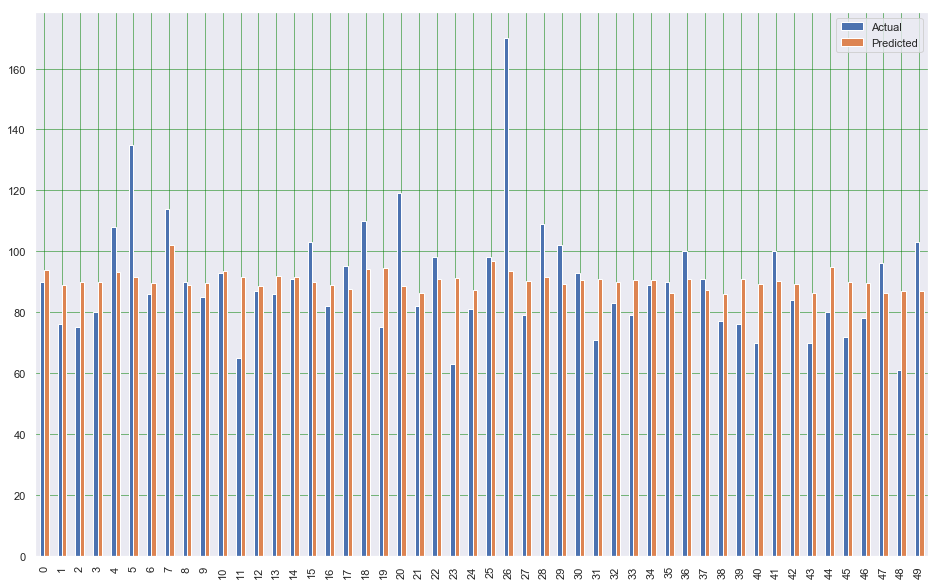

In [770]:
pred_fu_Fault_linear = lr.predict(df_fu_test_rain)
fu_actual_pred_linear= pd.DataFrame({'Actual': df_fu_test_fault.flatten(), 'Predicted': pred_fu_Fault_linear.flatten()})
bar_plot_df = fu_actual_pred_linear.head(50)
bar_plot_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

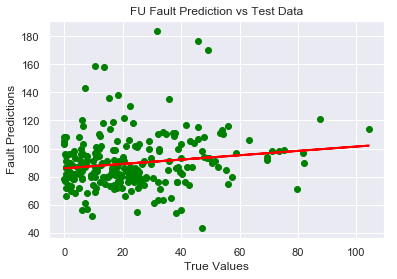

In [946]:
plt.scatter(df_fu_test_rain, df_fu_test_fault,  color='green')
plt.plot(df_fu_test_rain, pred_fu_Fault_linear, color='red', linewidth=2)
plt.title('FU Fault Prediction vs Test Data') 
plt.xlabel('True Values')
plt.ylabel('Fault Predictions')
plt.show()

In [772]:
rmspe_fu = (np.sqrt(np.mean(np.square((df_fu_test_fault - pred_fu_Fault_linear) / df_fu_test_fault)))) * 100
print('Root Mean Squared Error Percentage for FU Faults: ', rmspe_fu,'%')

Root Mean Squared Error Percentage for FU Faults:  21.349197306932357 %


# LN FAULT MODEL

## Linear Regression

In [773]:
df_ln = df[['Cummulative_Rain','15to21Faults_LN']]
df_ln_train, df_ln_test = train_test_split(df_ln, test_size=0.2,random_state=1801)

In [955]:
df_ln.corr()

,Cummulative_Rain,15to21Faults_LN
Cummulative_Rain,1.000000,0.440418
15to21Faults_LN,0.440418,1.000000


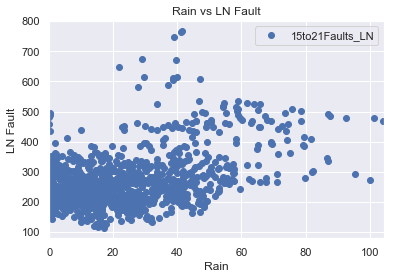

In [774]:
df_ln.plot(x='Cummulative_Rain', y='15to21Faults_LN', style='o')  
plt.title('Rain vs LN Fault')  
plt.xlabel('Rain')  
plt.ylabel('LN Fault')  
plt.show()

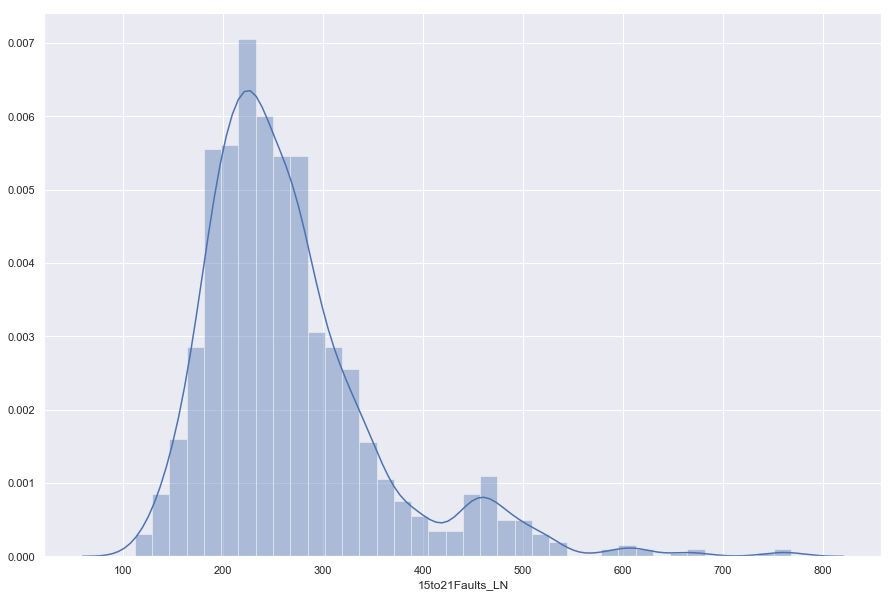

In [775]:
# Check Average Faults
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df_ln['15to21Faults_LN'])

In [776]:
# Find TRAIN Set Data for 15 to 21 Days for LN Faults
df_ln_train_np_rain=df_ln_train['Cummulative_Rain'].to_numpy()
df_ln_train_np_fault = df_ln_train['15to21Faults_LN'].to_numpy()

# Reshape test train data
df_ln_train_rain = df_ln_train_np_rain.reshape(len(df_ln_train_np_rain),1)
df_ln_train_fault = df_ln_train_np_fault.reshape(len(df_ln_train_np_fault),1)

In [777]:
lr = LinearRegression().fit(df_ln_train_rain,df_ln_train_fault)

In [778]:
lr.score(df_ln_train_rain, df_ln_train_fault)

0.18929831487567994

In [779]:
# Find TEST Set Data for 15 to 21 Days for FU Faults
df_ln_test_np_rain=df_ln_test['Cummulative_Rain'].to_numpy()
df_ln_test_np_fault = df_ln_test['15to21Faults_LN'].to_numpy()

df_ln_test_rain = df_ln_test_np_rain.reshape(len(df_ln_test_np_rain),1)
df_ln_test_fault = df_ln_test_np_fault.reshape(len(df_ln_test_np_fault),1)

In [780]:
# testing model accuracy in test set
lr.score(df_ln_test_rain, df_ln_test_fault)

0.21384722987389126

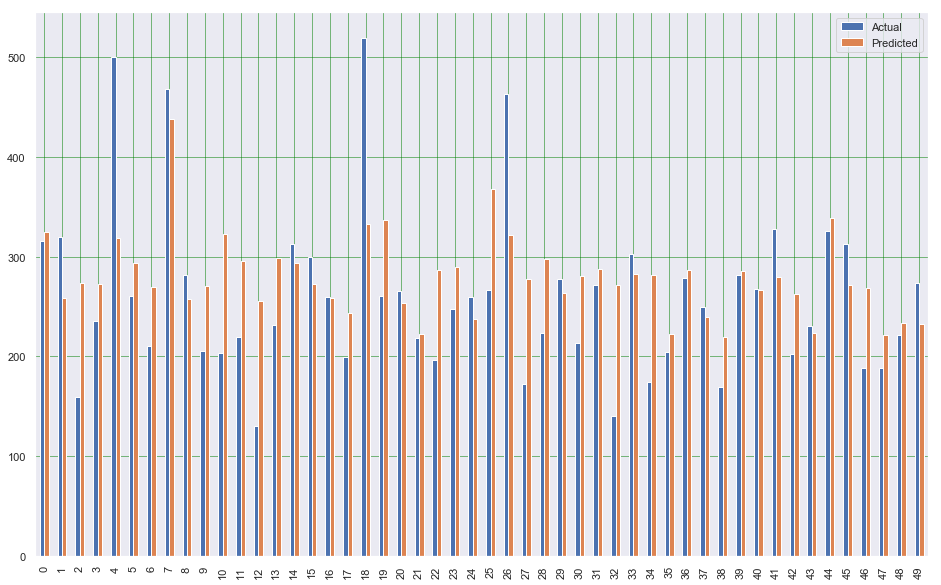

In [781]:
pred_ln_Fault_linear = lr.predict(df_ln_test_rain)
ln_actual_pred_linear= pd.DataFrame({'Actual': df_ln_test_fault.flatten(), 'Predicted': pred_ln_Fault_linear.flatten()})
bar_plot_df = ln_actual_pred_linear.head(50)
bar_plot_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

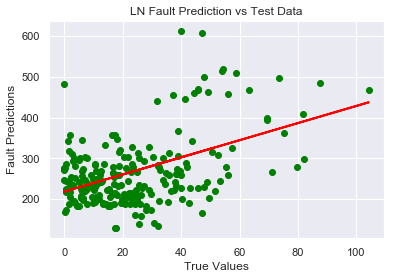

In [947]:
plt.scatter(df_ln_test_rain, df_ln_test_fault,  color='green')
plt.plot(df_ln_test_rain, pred_ln_Fault_linear, color='red', linewidth=2)
plt.title('LN Fault Prediction vs Test Data') 
plt.xlabel('True Values')
plt.ylabel('Fault Predictions')
plt.show()

In [783]:
rmspe_ln = (np.sqrt(np.mean(np.square((df_ln_test_fault - pred_ln_Fault_linear) / df_ln_test_fault)))) * 100
print('Root Mean Squared Error Percentage for LN Faults: ', rmspe_ln,'%')

Root Mean Squared Error Percentage for LN Faults:  29.48329493509179 %


# OTHER FAULT MODEL

## Linear Regression

In [784]:
df_other = df[['Cummulative_Rain','15to21Faults_OTHER']]
df_other_train, df_other_test = train_test_split(df_other, test_size=0.2,random_state=1801)

In [956]:
df_other.corr()

,Cummulative_Rain,15to21Faults_OTHER
Cummulative_Rain,1.000000,0.035445
15to21Faults_OTHER,0.035445,1.000000


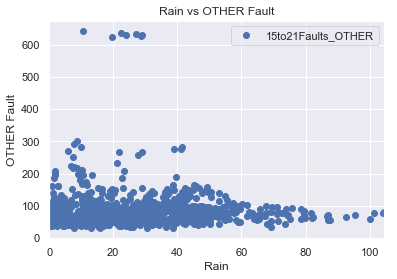

In [785]:
df_other.plot(x='Cummulative_Rain', y='15to21Faults_OTHER', style='o')  
plt.title('Rain vs OTHER Fault')  
plt.xlabel('Rain')  
plt.ylabel('OTHER Fault')  
plt.show()

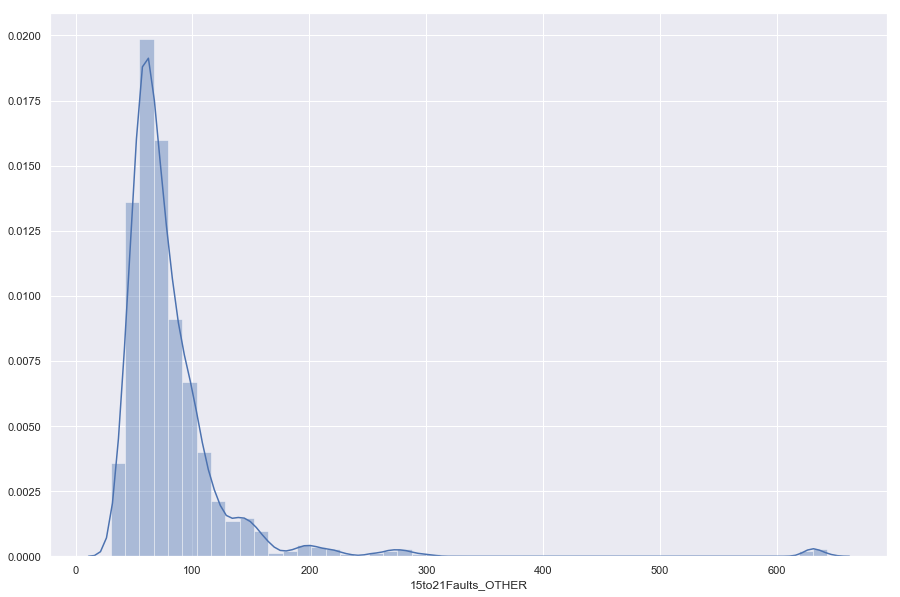

In [786]:
# Check Average Faults
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df_other['15to21Faults_OTHER'])

In [787]:
# Find TRAIN Set Data for 15 to 21 Days for OTHER Faults
df_other_train_np_rain=df_other_train['Cummulative_Rain'].to_numpy()
df_other_train_np_fault = df_other_train['15to21Faults_OTHER'].to_numpy()

# Reshape test train data
df_other_train_rain = df_other_train_np_rain.reshape(len(df_other_train_np_rain),1)
df_other_train_fault = df_other_train_np_fault.reshape(len(df_other_train_np_fault),1)

In [788]:
lr = LinearRegression().fit(df_other_train_rain,df_other_train_fault)

In [789]:
lr.score(df_other_train_rain, df_other_train_fault)

0.0014555832446628836

In [790]:
# Find TEST Set Data for 15 to 21 Days for OTHER Faults
df_other_test_np_rain=df_other_test['Cummulative_Rain'].to_numpy()
df_other_test_np_fault = df_other_test['15to21Faults_OTHER'].to_numpy()

df_other_test_rain = df_other_test_np_rain.reshape(len(df_other_test_np_rain),1)
df_other_test_fault = df_other_test_np_fault.reshape(len(df_other_test_np_fault),1)

In [791]:
# testing model accuracy in test set
lr.score(df_other_test_rain, df_other_test_fault)

-0.007530650746826684

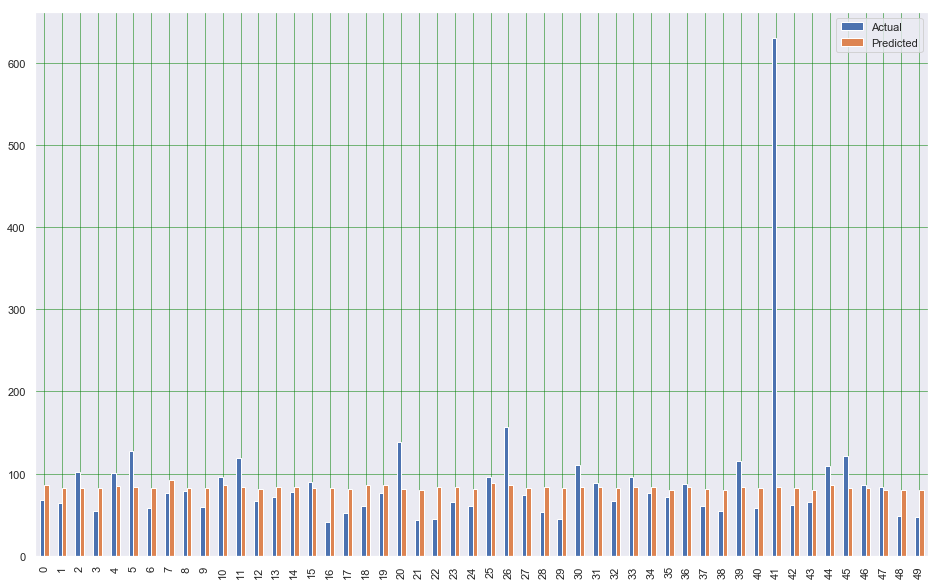

In [792]:
pred_other_Fault_linear = lr.predict(df_other_test_rain)
other_actual_pred_linear= pd.DataFrame({'Actual': df_other_test_fault.flatten(), 'Predicted': pred_other_Fault_linear.flatten()})
bar_plot_df = other_actual_pred_linear.head(50)
bar_plot_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

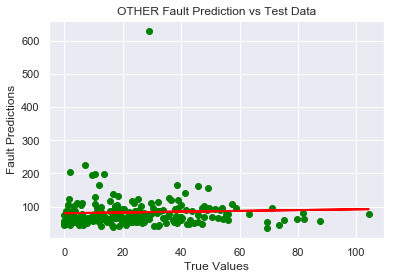

In [948]:
plt.scatter(df_other_test_rain, df_other_test_fault,  color='green')
plt.plot(df_other_test_rain, pred_other_Fault_linear, color='red', linewidth=2)
plt.title('OTHER Fault Prediction vs Test Data') 
plt.xlabel('True Values')
plt.ylabel('Fault Predictions')
plt.show()

In [794]:
rmspe_other = (np.sqrt(np.mean(np.square((df_other_test_fault - pred_other_Fault_linear) / df_other_test_fault)))) * 100
print('Root Mean Squared Error Percentage for Other Faults: ', rmspe_other,'%')

Root Mean Squared Error Percentage for Other Faults:  43.38603966237854 %


In [960]:
rmspe_other = (np.sqrt(np.mean(np.square((df_other_test_fault - pred_other_Fault_linear) / df_other_test_fault)))) * 100
print('Root Mean Squared Error Percentage for Other Faults: ', rmspe_other,'%')

Root Mean Squared Error Percentage for Other Faults:  43.38603966237854 %
